<a href="https://colab.research.google.com/github/susannatangg/comp646_assignments/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Image Question Answering with Shapes [10pts + 2 extra]**

### **0. Loading resources and installing extra libraries**

In [1]:
!pip install -q livelossplot
!wget -qnc https://www.cs.rice.edu/~vo9/deep-vislang/ShapesQA_trainset.zip
!unzip -q ShapesQA_trainset.zip
!mv synthetic_shapes_dataset ShapesQA_trainset
!wget -qnc https://www.cs.rice.edu/~vo9/deep-vislang/ShapesQA_valset.zip
!unzip -q ShapesQA_valset.zip
!mv synthetic_shapes_dataset ShapesQA_valset

### **1. Defining a Dataset class**

For this assignment we have created a novel dataset called ShapesQA which is a question answering dataset about images with simple geometric shapes consisting of triangles, circles and squares. The goal is to build a model that can answer questions for this dataset using all the tools at our disposal including for representing images and text.

In [59]:
import torch, json, random, os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text):
    return tokenizer.encode(text,add_special_tokens=True)

class ShapesQADataset(Dataset):
    def __init__(self, annotations = "",
                 image_dir = "", vocab = None,
                 transform = None,
                 max_question_len = 20):
        self.annotations = json.load(open(annotations))
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform if transform is not None else transforms.ToTensor()
        self.max_question_len = max_question_len
        # Define a fixed answer mapping (example: 6 colors, 3 shapes, 6 counts = 15 classes)
        self.answer2idx = {"red": 0, "blue": 1, "green": 2, "yellow": 3, "purple": 4, "orange": 5,
                      "circle": 6, "square": 7, "triangle": 8,
                      "0": 9, "1": 10, "2": 11, "3": 12, "4": 13, "5": 14}
        self.idx2answer = {v: k for k, v in self.answer2idx.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.image_dir, ann["image"])
        image = Image.open(image_path).convert("RGB")

        # Apply image transformation if specified.
        if self.transform:
            image = self.transform(image)

        question = ann["question"]
        # Apply tokenization to input question if specified.
        if self.vocab:
          tokens = tokenize(question)
          indices = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
          if len(indices) < self.max_question_len:
              indices = indices + [self.vocab["<pad>"]] * (self.max_question_len - len(indices))
          else:
              indices = indices[:self.max_question_len]
          question = torch.tensor(indices, dtype=torch.long)
        answer = str(ann["answer"])
        label = self.answer2idx.get(answer, 0)
        label = torch.tensor(label, dtype=torch.long)

        return {"image": image, "question": question, "answer": label, "question_type": ann["question_type"]}

trainset = ShapesQADataset(annotations="ShapesQA_trainset/annotations.json",
                           vocab = None,
                           image_dir="ShapesQA_trainset")
valset = ShapesQADataset(annotations="ShapesQA_valset/annotations.json",
                         vocab = None,
                         image_dir="ShapesQA_valset")

print("Num training images: ", len(trainset))
print("Num validation images: ", len(valset))

Num training images:  1000
Num validation images:  1000


Now let's show a random example from this dataset. Look at many examples by running this code several times to get an idea of the difficulty of the problem.

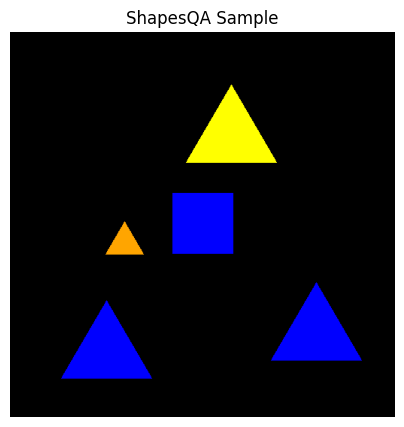

Question: Which color is the object found left of the blue square?
Answer: orange
Question type: left_right


In [24]:
def show_sample(sample):
    image_tensor = sample["image"]
    image_np = image_tensor.permute(1, 2, 0).numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(image_np); plt.axis("off")
    plt.title("ShapesQA Sample"); plt.show()
    print("Question:", sample["question"])
    print("Answer:", trainset.idx2answer[sample["answer"].item()])
    print("Question type:", sample["question_type"])

# Display a random sample.
sample_idx = random.randint(0, len(valset) - 1)
sample = valset[sample_idx]
show_sample(sample)

### **2. Defining how batches are loaded**

Here we define how data samples are going to be converted to batch tensors when creating a data loader. Another common step in setting up our problem. In this case, text input needs to be handled such that they can be put in batches despite different questions having different lengths in terms of number of words. A common strategy is to tokenize the input, convert to numerical ids for every word by creating a dictionary (vocabulary) and then using special tokens for words outside the vocabulary and for padding the texts so they all end up with the same length in a batch.

In [3]:
from collections import Counter
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text):
    # Tokenizing using the BertTokenizer
    return tokenizer.encode(text,add_special_tokens=True)

def build_vocab(questions, min_freq=1):
    """Builds a word2idx dictionary from a list of question strings."""
    counter = Counter()
    for q in questions:
        tokens = tokenize(q)
        counter.update(tokens)
    # Reserve index 0 for <pad> and 1 for <unk>
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# The collate_fn is a special function in pytorch to indicate how batches
# should be assembled.
def collate_fn(batch):
    images = torch.stack([item["image"] for item in batch], dim=0)
    questions = torch.stack([item["question"] for item in batch], dim=0)
    answers = torch.stack([item["answer"] for item in batch], dim=0)
    # Collect question types as a list of strings.
    question_types = [item["question_type"] for item in batch]
    return {"image": images, "question": questions, "answer": answers, "question_type": question_types}


train_annotations = json.load(open("ShapesQA_trainset/annotations.json"))
all_train_questions = [ann["question"] for ann in train_annotations]
vocab = build_vocab(all_train_questions, min_freq=1)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# Sample code for loading one batch.
trainset = ShapesQADataset(annotations="ShapesQA_trainset/annotations.json",
                           vocab = vocab,
                           image_dir="ShapesQA_trainset")
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate_fn)
for batch in train_loader:
    images = batch["image"]
    questions = batch["question"]
    answers = batch["answer"]
    question_types = batch["question_type"]
    print("Image batch shape:", images.shape)
    print("Question batch shape:", questions.shape)
    print("Answer batch shape:", answers.shape)
    print("Question type shape:", question_types)
    break


Vocabulary size: 56
Image batch shape: torch.Size([32, 3, 512, 512])
Question batch shape: torch.Size([32, 20])
Answer batch shape: torch.Size([32])
Question type shape: ['extreme', 'unique', 'unique', 'count', 'count', 'extreme', 'unique', 'extreme', 'count', 'unique', 'extreme', 'unique', 'unique', 'extreme', 'count', 'count', 'count', 'extreme', 'count', 'left_right', 'extreme', 'count', 'unique', 'extreme', 'extreme', 'left_right', 'extreme', 'count', 'extreme', 'extreme', 'count', 'extreme']


### **3. Defining a model to solve this problem [1pt]**

Create a model to solve this problem. This model takes as input a batch of texts (questions) and images, and outputs an answer.

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertModel, BertTokenizer

class VQAModel(nn.Module):
    # Feel free to add/adjust parameters here as needed.
    def __init__(self, vocab_size, num_answers, embed_dim=300, hidden_dim=512, dropout=0.5):
        super(VQAModel, self).__init__()

        # Pretrained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_fc = nn.Linear(768, hidden_dim)

        # Pretrained CNN (ResNet) to extract image features
        resnet = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cnn_fc = nn.Linear(512, hidden_dim)

        # Dropout and fully connected layer for classification
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_answers)

    def forward(self, images, questions, attention_mask=None):
        #extract image features
        img_features = self.cnn(images).squeeze(-1).squeeze(-1)
        img_features = self.cnn_fc(img_features)
        img_features = self.dropout(img_features)

        #encode question using bert
        outputs = self.bert(questions, attention_mask=attention_mask)
        question_features = outputs.pooler_output
        question_features = self.bert_fc(question_features)
        question_features = self.dropout(question_features)

        #concatenate image and question features
        combined_features = torch.cat((img_features, question_features), dim=1)

        #output logits (raw predictions)
        logits = self.fc(combined_features)
        return logits


# Example usage using a random dummy input.
vocab_size = 1000
num_answers = 15  # e.g., 6 colors + 3 shapes + 6 count answers
model = VQAModel(vocab_size, num_answers)
images = torch.randn(32, 3, 256, 256)  # (batch, channels, height, width)
questions = torch.randint(0, vocab_size, (32, 20))
logits = model(images, questions)
print("Output shape:", logits.shape)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


Output shape: torch.Size([32, 15])


### **4. Training Loop [2pt]**

This is the standard training loop. One requirement is that you need to use at least two forms of data augmentation. The required accuracy for this part is at minimum 40% overall accuracy across all types of questions. The result from this section and the next have to be reported in this [spreadsheet](https://docs.google.com/spreadsheets/d/1Iyc6_QH07X0xxTGX_4H1tY1TS5Xqj3VltDPBr3PKyiQ/edit?usp=sharing).

In [51]:
# ============================================================
# Create Vocabulary for the tokenizer.
# ============================================================
train_annotations_file = "ShapesQA_trainset/annotations.json"
val_annotations_file   = "ShapesQA_valset/annotations.json"
train_image_dir = "ShapesQA_trainset"
val_image_dir   = "ShapesQA_valset"

with open(train_annotations_file, "r") as f:
    train_annotations = json.load(f)
with open(val_annotations_file, "r") as f:
    val_annotations = json.load(f)

all_train_questions = [ann["question"] for ann in train_annotations]
vocab = build_vocab(all_train_questions, min_freq=1)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# ============================================================
# Create Datasets and DataLoaders
# ============================================================
# You are required to make some changes here as specified earlier.
train_image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ShapesQADataset(annotations=train_annotations_file,
                           image_dir=train_image_dir,
                           vocab=vocab,
                           transform=train_image_transform,
                           max_question_len=20)
val_dataset = ShapesQADataset(annotations=val_annotations_file,
                         image_dir=val_image_dir,
                         vocab=vocab,
                         transform=image_transform,
                         max_question_len=20)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# ============================================================
# Initialize Model, Loss, and Optimizer
# ============================================================

num_answers = 15  # e.g., 6 colors + 3 shapes + 6 count answers
model = VQAModel(vocab_size, num_answers=num_answers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Feel free to change this to whatever you consider most appropriate.
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# ============================================================
# Training and Validation Loops with Livelossplot
# ============================================================
# NOTE: Feel free to modify any of the code below. This is just what worked
# for me with the model I created.

from livelossplot import PlotLosses

liveplot = PlotLosses()
# Feel free to change any hyperparameters here.
num_epochs = 30  # Total epochs

# Define the epoch at which to unfreeze the CNN branch.
freeze_epochs = 20 # Freeze for the first 18 epochs, unfreeze for the last 2 epochs

scaler = torch.cuda.amp.GradScaler()

def train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs):

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Unfreeze CNN parameters at the start of epoch freeze_epochs.
        if epoch == freeze_epochs:
            print("Unfreezing CNN parameters for fine-tuning...")
            for param in model.cnn.parameters():
                param.requires_grad = True
            # Update the optimizer to include the newly unfrozen CNN parameters.
            # optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            images = batch["image"].to(device)         # (batch, 3, H, W)
            questions = batch["question"].to(device)     # (batch, max_question_len)
            answers = batch["answer"].to(device)         # (batch,)

            attention_mask = (questions != 0).long().to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
              logits = model(images, questions,attention_mask)            # (batch, num_answers)
              loss = criterion(logits, answers)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == answers).sum().item()
            total_train += answers.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                questions = batch["question"].to(device)
                answers = batch["answer"].to(device)

                attention_mask = (questions != 0).long().to(device)

                logits = model(images, questions,attention_mask)
                loss = criterion(logits, answers)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == answers).sum().item()
                total_val += answers.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        scheduler.step(val_acc)

        liveplot.update({
            'loss': avg_train_loss,
            'accuracy': train_acc,
            'val_loss': avg_val_loss,
            'val_accuracy': val_acc,
        })
        liveplot.send()

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
            f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model

Vocabulary size: 56


<ipython-input-51-c3b5ec8bf0a8>:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


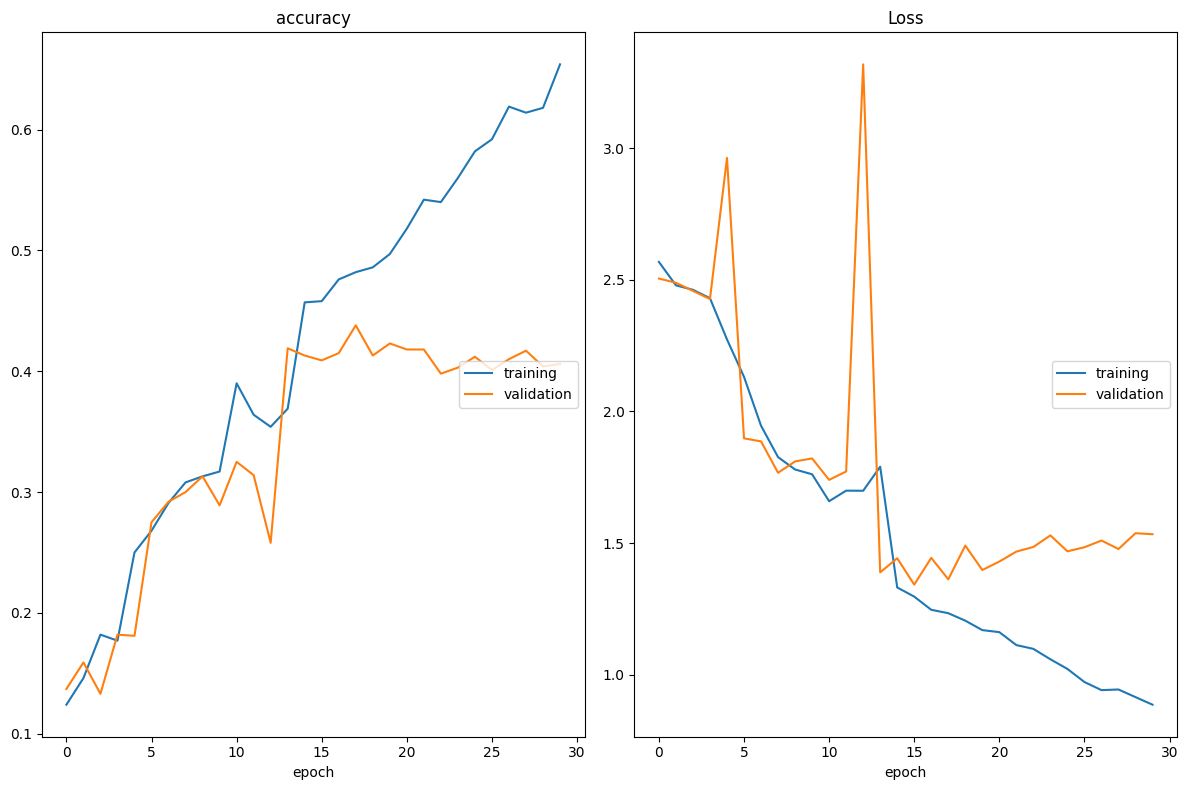

accuracy
	training         	 (min:    0.124, max:    0.654, cur:    0.654)
	validation       	 (min:    0.133, max:    0.438, cur:    0.406)
Loss
	training         	 (min:    0.886, max:    2.568, cur:    0.886)
	validation       	 (min:    1.342, max:    3.319, cur:    1.534)
Epoch 30/30: Train Loss = 0.8860, Train Acc = 0.6540, Val Loss = 1.5337, Val Acc = 0.4060


In [ ]:
model = train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs)

### **5. Further Evaluating this model**

Let's evaluate the model again but now let's breakdown its performance by type of question. Report your results in this [spreadsheet](https://docs.google.com/spreadsheets/d/1Iyc6_QH07X0xxTGX_4H1tY1TS5Xqj3VltDPBr3PKyiQ/edit?usp=sharing):

In [ ]:
# --- Compute accuracy per question type on the validation set ---
model.eval()
type_correct = {}  # Dictionary to count correct predictions per type.
type_total = {}    # Dictionary to count total samples per type.

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        questions = batch["question"].to(device)
        answers = batch["answer"].to(device)
        q_types = batch["question_type"]  # List of question type strings for this batch

        attention_mask = (questions != 0).long().to(device)
        logits = model(images, questions, attention_mask)  # (batch, num_answers)
        preds = torch.argmax(logits, dim=1)  # (batch,)

        # Loop over each sample in the batch.
        for i, qt in enumerate(q_types):
            if qt not in type_total:
                type_total[qt] = 0
                type_correct[qt] = 0
            type_total[qt] += 1
            if preds[i] == answers[i]:
                type_correct[qt] += 1

print("\nValidation Accuracy per Question Type:")
for qt in type_total:
    accuracy = type_correct[qt] / type_total[qt]
    print(f"  Question type '{qt}': Accuracy = {accuracy:.4f} ({type_correct[qt]}/{type_total[qt]})")


Validation Accuracy per Question Type:
  Question type 'count': Accuracy = 0.3123 (99/317)
  Question type 'extreme': Accuracy = 0.3709 (112/302)
  Question type 'unique': Accuracy = 0.5238 (176/336)
  Question type 'left_right': Accuracy = 0.4222 (19/45)


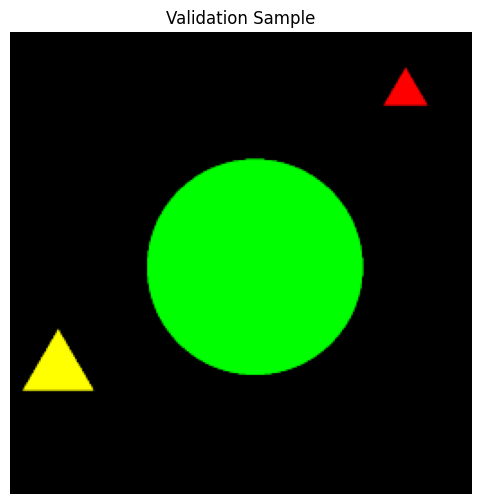

Original Question:
What color is the biggest circle in the image?

Ground Truth Answer:
green

Predicted Answer:
green


In [ ]:
# ============================================================
#  Display a Sample Prediction from Validation Set
# ============================================================

# Define the answer mapping (same as used in your dataset)
answer2idx = {
    "red": 0, "blue": 1, "green": 2, "yellow": 3, "purple": 4, "orange": 5,
    "circle": 6, "square": 7, "triangle": 8,
    "0": 9, "1": 10, "2": 11, "3": 12, "4": 13, "5": 14
}
idx2answer = {v: k for k, v in answer2idx.items()}

# --- Display a sample prediction from the validation set ---

# Pick a random index from the validation dataset
val_idx = random.randint(0, len(val_dataset) - 1)
sample = val_dataset[val_idx]  # sample from the custom Dataset; contains tokenized question, image, label
val_annotations = json.load(open(val_annotations_file))

# Retrieve the original annotation for the chosen sample
original_ann = val_annotations[val_idx]
original_question = original_ann["question"]
ground_truth_answer = str(original_ann["answer"])

# Prepare the sample for model prediction (add batch dimension)
model.eval()
image = sample["image"].unsqueeze(0).to(device)        # shape: (1, 3, H, W)
question = sample["question"].unsqueeze(0).to(device)    # shape: (1, max_question_len)
with torch.no_grad():
    logits = model(image, question)                      # shape: (1, num_answers)
    pred_idx = torch.argmax(logits, dim=1).item()
predicted_answer = idx2answer[pred_idx]

# Display the image
sample_img = image[0].cpu().permute(1, 2, 0).numpy()
plt.figure(figsize=(6,6))
plt.imshow(sample_img)
plt.axis("off")
plt.title("Validation Sample")
plt.show()

# Print the original question, ground truth answer, and predicted answer
print("Original Question:")
print(original_question)
print("\nGround Truth Answer:")
print(ground_truth_answer)
print("\nPredicted Answer:")
print(predicted_answer)

## **Assignment Questions**

#### **1. Random Guesser Accuracy [0.5pts]**
What is the accuracy of a model that takes a random guess to provide an answer and ignores the input question and input image? Show your calculation in the cell below.

In [ ]:
# Your code or logic goes here.

#by logic, every answer in a random guess model has equal probability

train_annotations_file = "ShapesQA_trainset/annotations.json"

with open(train_annotations_file, "r") as f:
    train_annotations = json.load(f)

answer_counts = Counter(ann["answer"] for ann in train_annotations)
num_answers = len(answer_counts)

random_guess_acc = 1/num_answers
print(f"Expected accuracy of a random guess model: {random_guess_acc:.4%}")


Expected accuracy of a random guess model: 6.6667%


#### **2. Zero-knowledge Accuracy [0.5pts]**
What is the accuracy of a model that guesses but takes advantage of the probability distribution of answers in the training set. Show your calculation in the cell below.

In [ ]:
# Your code or logic goes here.

train_annotations_file = "ShapesQA_trainset/annotations.json"
with open(train_annotations_file, "r") as f:
    train_annotations = json.load(f)

answer_counts = Counter(ann["answer"] for ann in train_annotations)
total_answers = sum(answer_counts.values())
answer_probabilities = {answer: count / total_answers for answer, count in answer_counts.items()}

expected_accuracy = sum(prob**2 for prob in answer_probabilities.values())

print(f"Expected accuracy of biased random guess model: {expected_accuracy:.4f}")

Expected accuracy of biased random guess model: 0.0957


#### **3. Oracle-question Guesser Accuracy [1pt]**
What is the accuracy of a model that has a way of knowing exactly the type of question being asked but guesses randomly conditioned on this knowledge. Assume that the types of questions are equally distributed in the training and validation sets. Show your calculations in the cell below.

In [ ]:
# Your code or logic goes here.

from collections import defaultdict

train_annotations_file = "ShapesQA_trainset/annotations.json"
with open(train_annotations_file, "r") as f:
    train_annotations = json.load(f)

#group answers by question type
question_type_to_answers = defaultdict(set)

for ann in train_annotations:
  question_type = ann["question_type"]
  answer = ann["answer"]
  question_type_to_answers[question_type].add(answer)

question_type_probabilities = {q_type: 1/len(answers) for q_type, answers in question_type_to_answers.items()}
expected_accuracy = sum(question_type_probabilities.values()) / len(question_type_probabilities)

print(f"Expected accuracy of a model that guesses randomly per question type: {expected_accuracy:.4f}")

Expected accuracy of a model that guesses randomly per question type: 0.1944


#### **4. Extra Data Generation [2pts]**

Train a better model by generating more training data. You are encouraged to use a coding assistant to generate more data that is as close as possible as the training data provided for the assignment. Include your prompts here and/or link to the coding assistant history. In any case, include here code for generating the extra data. Use up to 10x the amount of training images. You are required to improve your base model by at least 5% without changing anything in the model. Your results should be reported in this [spreadsheet](https://docs.google.com/spreadsheets/d/1mqy9p5HN4KK_LQIz2sGFR_eFezkcr53o-MBTtfSjzXE/edit?usp=sharing).

ChatGPT 4o chat: https://chatgpt.com/share/67bd3f3f-09a4-800e-a858-84e5d834cf7a


In [43]:
import os
import json
import random
import shutil
from PIL import Image, ImageDraw
from typing import List, Dict, Optional

image_size = 256
num_samples = 9000
output_dir = "ShapesQA_generated"
annotations_file = "ShapesQA_generated/annotations.json"

# constants to randomly choose from
colors = ["red", "blue", "green", "yellow", "purple", "orange"]
shapes = ["circle", "square", "triangle"]
question_types = ["count", "unique", "extreme", "left_right"]
count_phrasings = [  # 0:color, 1:shape
    "How many {0} {1}s are in the image?",
    "What is the number of {0} {1}s in the picture?",
    "Count the {0} {1}s in the image.",
    "Can you tell me how many {0} {1}s are in the image?",
    "What is the total count of {0} {1}s in the picture?",
    "Identify the number of {0} {1}s present in the image.",
    "Give me the count of {0} {1}s in this picture.",
    "How many instances of {0} {1}s do you see in the image?",
    "Please determine the number of {0} {1}s in the image.",
    "Find and count all the {0} {1}s in the picture."
]
left_right_phrasings = [  # 0:color, 1:shape
    "Which color is the object found to the right of the {0} {1}?",
    "Which color is the object located to the left of the {0} {1}?",
    "What is the color of the object to the right of the {0} {1}?",
    "What color is the object positioned to the left of the {0} {1}?",
    "Identify the color of the object that appears to the right of the {0} {1}.",
    "Tell me the color of the object found to the left of the {0} {1}.",
    "To the right of the {0} {1}, what color is the object?",
    "To the left of the {0} {1}, what color is the object?",
    "Which colored object is immediately to the right of the {0} {1}?",
    "Which colored object is immediately to the left of the {0} {1}?",
    "What is the color of the object directly to the right of the {0} {1}?",
    "What is the color of the object directly to the left of the {0} {1}?",
    "Look to the right of the {0} {1}. What color is the object there?",
    "Look to the left of the {0} {1}. What color is the object there?",
    "Find the object to the right of the {0} {1}. What color is it?",
    "Find the object to the left of the {0} {1}. What color is it?"
]
unique_phrasings = [  # 0:shape
    "What is the color of the {0}?",
    "Can you tell me the color of the {0}?",
    "What color is the {0}?",
    "Identify the color of the {0}.",
    "Which color does the {0} have?",
    "Tell me the color of the {0}.",
    "What shade is the {0}?",
    "Determine the color of the {0}.",
    "What hue is the {0}?",
    "Could you specify the color of the {0}?",
    "Do you know the color of the {0}?",
    "Find out the color of the {0}.",
    "State the color of the {0}.",
    "Which color describes the {0}?",
    "Describe the color of the {0}."
]
extreme_phrasings = [  # 0:extreme_type, 1:shape
    "What is the color of the {0} {1}?",
    "Can you tell me the color of the {0} {1}?",
    "What color is the {0} {1}?",
    "Identify the color of the {0} {1}.",
    "Which color does the {0} {1} have?",
    "Tell me the color of the {0} {1}.",
    "What shade is the {0} {1}?",
    "Determine the color of the {0} {1}.",
    "What hue is the {0} {1}?",
    "Could you specify the color of the {0} {1}?",
    "Do you know the color of the {0} {1}?",
    "Find out the color of the {0} {1}.",
    "State the color of the {0} {1}.",
    "Which color describes the {0} {1}?",
    "Describe the color of the {0} {1}.",
    "What is the hue of the {0} {1}?",
    "Which hue best represents the {0} {1}?",
    "What distinct color does the {0} {1} have?",
    "Can you determine the color of the {0} {1}?",
    "Observe the {0} {1} and state its color."
]

# copy all the data from original trainset into new trainset
def setup_directory():
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    source_dir = "ShapesQA_trainset"
    for file_name in os.listdir(source_dir):
        source_path = os.path.join(source_dir, file_name)
        destination_path = os.path.join(output_dir, file_name)
        if os.path.isfile(source_path) and file_name != "annotations.json":
            shutil.copy2(source_path, destination_path)

    source_annotations = os.path.join(source_dir, "annotations.json")
    if os.path.exists(source_annotations):
        destination_annotations = annotations_file
        with open(source_annotations, "r") as f:
            existing_annotations = json.load(f)
        with open(destination_annotations, "w") as f:
            json.dump(existing_annotations, f)
        print(f"Copied annotations.json with {len(existing_annotations)} entries.")

    num_files = len([f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))])
    print(f"Number of files in '{output_dir}': {num_files}")

# check if shapes overlap
def shapes_overlap(shape1, shape2):
    x1, y1, x2, y2 = shape1["coords"]
    x3, y3, x4, y4 = shape2["coords"]
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)

# generate a random shape
def generate_shape(draw, existing_shapes, color, shape):
    max_attempts = 100
    for _ in range(max_attempts):
        size = random.randint(20, 50)
        x = random.randint(0, image_size - size)
        y = random.randint(0, image_size - size)
        coords = [x, y, x + size, y + size]
        new_shape = {"shape": shape, "color": color, "size": size, "coords": coords}
        if not any(shapes_overlap(new_shape, existing) for existing in existing_shapes):
            if shape == "circle":
                draw.ellipse(coords, fill=color)
            elif shape == "square":
                draw.rectangle(coords, fill=color)
            elif shape == "triangle":
                triangle_coords = [(x, y + size), (x + size, y + size), (x + size // 2, y)]
                draw.polygon(triangle_coords, fill=color)
            return new_shape
    generate_shape(draw, existing_shapes, color, shape)

# generate a random question from given templates
def generate_question(shapes_in_image):
    question_type = random.choice(question_types)

    if question_type == "count":
        # asks how many of a certain colored shape there is
        color = random.choice(colors)
        shape = random.choice(shapes)
        question = random.choice(count_phrasings).format(color,shape)
        answer = str(sum(1 for s in shapes_in_image if s["color"] == color and s["shape"] == shape))

    elif question_type == "unique":
        # ask for the color of shapes that appear exactly once
        shape_counts = {}
        for s in shapes_in_image:
            shape_counts[s["shape"]] = shape_counts.get(s["shape"], 0) + 1
        unique_shapes = [shape for shape, count in shape_counts.items() if count == 1]
        if not unique_shapes:
            return generate_question(shapes_in_image)
        shape = random.choice(unique_shapes)
        question = random.choice(unique_phrasings).format(shape)
        answer = next(s["color"] for s in shapes_in_image if s["shape"] == shape)

    elif question_type == "extreme":
        # asks for the color of the largest/smallest of a specified shape
        extreme_type = random.choice(["largest", "smallest"])
        shape_groups = {}
        for s in shapes_in_image:
            if s["shape"] not in shape_groups:
                shape_groups[s["shape"]] = []
            shape_groups[s["shape"]].append(s)
        shape = random.choice(list(shape_groups.keys()))
        question = random.choice(extreme_phrasings).format(extreme_type, shape)
        shapes_of_type = shape_groups[shape]
        answer = max(shapes_of_type, key=lambda x: x["size"])["color"] if extreme_type == "largest" \
                else min(shapes_of_type, key=lambda x: x["size"])["color"]

    elif question_type == "left_right":
        # asks for the color of the shape to the left/right of a given color and shape
        reference_object = random.choice(shapes_in_image[1:-1])
        ref_index = shapes_in_image.index(reference_object)
        direction = random.choice(["left", "right"])

        target_object = None
        if direction == "left" and ref_index > 0:
            target_object = shapes_in_image[ref_index - 1]
        elif direction == "right" and ref_index < len(shapes_in_image) - 1:
            target_object = shapes_in_image[ref_index + 1]

        if target_object:
            question = random.choice(left_right_phrasings).format(reference_object["color"], reference_object["shape"])
            answer = target_object["color"]

    return {"question": question, "answer": answer, "question_type": question_type}


setup_directory()
annotations = []

for i in range(1001,1001+num_samples):
    image = Image.new("RGB", (image_size, image_size), "black")
    draw = ImageDraw.Draw(image)

    #generate shapes
    shapes_in_image = []
    num_shapes = 5
    attempts = 0
    max_attempts = 50

    # add random color/shapes into a list
    while len(shapes_in_image) < num_shapes and attempts < max_attempts:
        color = random.choice(colors)
        shape = random.choice(shapes)
        shape_info = generate_shape(draw, shapes_in_image, color, shape)

        if shape_info:
            shapes_in_image.append(shape_info)
        attempts += 1

    # save image file and update annotations
    if len(shapes_in_image) == num_shapes:
        image_filename = f"synthetic_{i:04d}.png"
        image_path = os.path.join(output_dir, image_filename)
        image.save(image_path)

        qa_pair = generate_question(shapes_in_image)
        annotation = {
            "image": image_filename,
            "question": qa_pair["question"],
            "answer": qa_pair["answer"],
            "question_type": qa_pair["question_type"]
        }
        annotations.append(annotation)

print(annotations[-1])

#save annotations
with open(annotations_file, "w") as f:
    json.dump(annotations, f)

print(f"Generated {len(annotations)} valid samples.")
print(f"Number of files in '{output_dir}': {len(os.listdir(output_dir))}")

Copied annotations.json with 1000 entries.
Number of files in 'ShapesQA_generated': 1001
{'image': 'synthetic_10000.png', 'question': 'Find the object to the right of the red circle. What color is it?', 'answer': 'red', 'question_type': 'left_right'}
Generated 9000 valid samples.
Number of files in 'ShapesQA_generated': 10001


Training Loop

7431


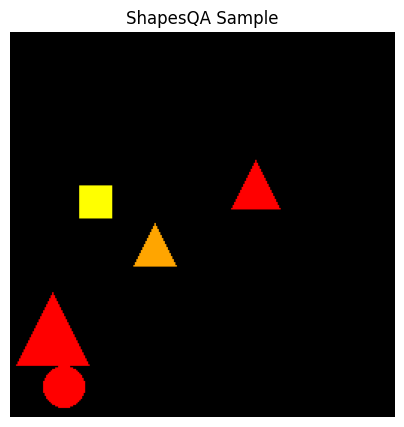

Image file name: synthetic_8432.png
Question: Count the yellow circles in the image.
Answer: 0
Question type: count


In [48]:
train_dataset = ShapesQADataset(annotations="ShapesQA_generated/annotations.json",
                           vocab = None,
                           image_dir="ShapesQA_generated")

def show_sample(sample, idx, annotations):
    image_tensor = sample["image"]
    image_np = image_tensor.permute(1, 2, 0).numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(image_np); plt.axis("off")
    plt.title("ShapesQA Sample"); plt.show()
    print("Image file name:", annotations[idx]["image"])
    print("Question:", sample["question"])
    print("Answer:", train_dataset.idx2answer[sample["answer"].item()])
    print("Question type:", sample["question_type"])

# Display a random sample.
sample_idx = random.randint(0, len(train_dataset) - 1)
print(sample_idx)
sample = train_dataset[sample_idx]
show_sample(sample, sample_idx, train_dataset.annotations)

In [52]:
# Your training loop goes here.

# ============================================================
# Create Vocabulary for the tokenizer.
# ============================================================
generated_annotations_file = "ShapesQA_generated/annotations.json"
val_annotations_file = "ShapesQA_valset/annotations.json"

with open(generated_annotations_file, "r") as f:
    generated_annotations = json.load(f)

with open(val_annotations_file, "r") as f:
    val_annotations = json.load(f)

print(len(generated_annotations))

all_train_questions = [ann["question"] for ann in generated_annotations]
vocab = build_vocab(all_train_questions, min_freq=1)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# ============================================================
# Create Datasets and DataLoaders
# ============================================================
train_image_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ShapesQADataset(
    annotations=generated_annotations_file,
    image_dir="ShapesQA_generated",
    vocab=vocab,
    transform=train_image_transform,
    max_question_len=20
)

val_dataset = ShapesQADataset(
    annotations=val_annotations_file,
    image_dir="ShapesQA_valset",
    vocab=vocab,
    transform=image_transform,
    max_question_len=20
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print("Trainset length: ", len(train_dataset))
print("Valset length: ", len(val_dataset))

# ============================================================
# Initialize Model, Loss, and Optimizer
# ============================================================
# num_answers = 15  # e.g., 6 colors + 3 shapes + 6 count answers
# model = VQAModel(vocab_size, num_answers=num_answers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# ============================================================
# Training and Validation Loops with Livelossplot
# ============================================================
from livelossplot import PlotLosses

liveplot = PlotLosses()
num_epochs = 30

# Define the epoch at which to unfreeze the CNN branch.
freeze_epochs = 20 # Freeze for the first 18 epochs, unfreeze for the last 2 epochs

scaler = torch.cuda.amp.GradScaler()

def train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs):

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Unfreeze CNN parameters at the start of epoch freeze_epochs.
        if epoch == freeze_epochs:
            print("Unfreezing CNN parameters for fine-tuning...")
            for param in model.cnn.parameters():
                param.requires_grad = True

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            images = batch["image"].to(device)         # (batch, 3, H, W)
            questions = batch["question"].to(device)     # (batch, max_question_len)
            answers = batch["answer"].to(device)         # (batch,)

            attention_mask = (questions != 0).long().to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
              logits = model(images, questions,attention_mask)            # (batch, num_answers)
              loss = criterion(logits, answers)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == answers).sum().item()
            total_train += answers.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                questions = batch["question"].to(device)
                answers = batch["answer"].to(device)

                attention_mask = (questions != 0).long().to(device)

                logits = model(images, questions,attention_mask)
                loss = criterion(logits, answers)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == answers).sum().item()
                total_val += answers.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        scheduler.step(val_acc)

        liveplot.update({
            'loss': avg_train_loss,
            'accuracy': train_acc,
            'val_loss': avg_val_loss,
            'val_accuracy': val_acc,
        })
        liveplot.send()

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
            f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

    model.load_state_dict(best_model_state)
    return model

9000
Vocabulary size: 83
Trainset length:  9000
Valset length:  1000


<ipython-input-52-166b026f3896>:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
model = train_model(model, optimizer, train_loader, val_loader, num_epochs, freeze_epochs)

#### **5. Revisiting Assignment 1: Zero-shot Image Classification with CLIP [3pts]**



In January 2021, OpenAI published a research paper named CLIP ([Contrastive Language-Image Pretraining](https://arxiv.org/abs/2103.00020)) https://openai.com/blog/clip/. This model was trained to maximize the dot product between vector representations of text and images that have a direct correspondence and minimize their dot product when they do not correspond. One key property of this model is that it can be used to build zero-shot classifier. Since the model was trained on a large number of images and text from the web, this model knows about a lot of categories of things. Your goal in this section is to obtain the best results using the illustrated approach in this figure for the scene classification problem of Assignment 1 (SUN20). Please enter the best classification accuracy in the [leaderboard](https://docs.google.com/spreadsheets/d/1mKXal0_abpq3cyAisfjI1xnWxNfIsYxvej5GPcrDf5M/edit?usp=sharing) here using CLIP. [To get full points obtain more than 94% accuracy and your code should run in less than 60 seconds]. Feel free to use other versions of CLIP, e.g. MetaCLIP (https://github.com/facebookresearch/MetaCLIP), OpenCLIP (https://github.com/mlfoundations/open_clip), EVA-CLIP (https://github.com/baaivision/EVA).

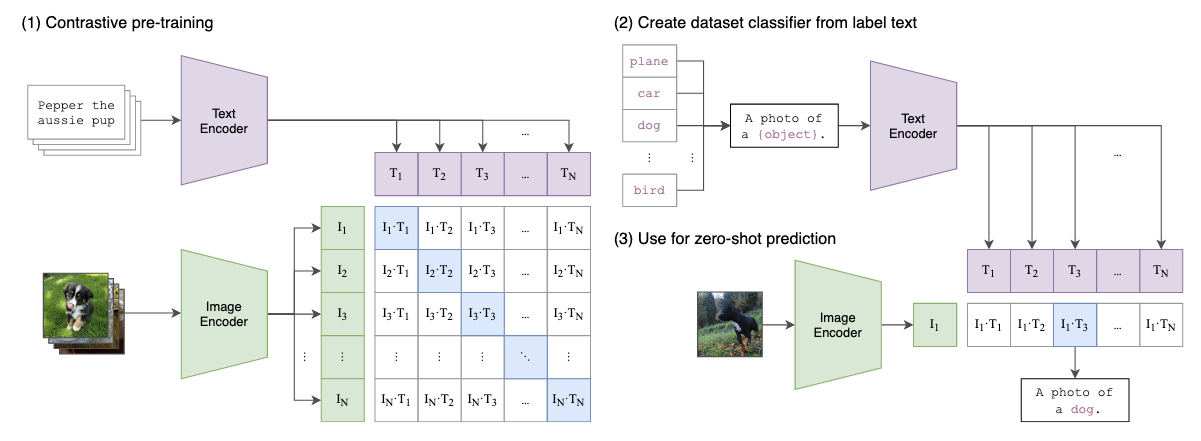

In [ ]:
# This command downloads the files with the prepackaged contents.
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz
!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm
!pip install open-clip-torch

File ‘SUN20-train-sm.tar.gz’ already there; not retrieving.

File ‘SUN20-val.tar.gz’ already there; not retrieving.

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qjuwiokn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qjuwiokn
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):

    # These are the 20 categories selected.
    self.categories = open(f'SUN20/{split}/ClassName.txt').read().strip().split('\n')
    self.categories = sorted(self.categories)
    self.category2index = {cat: idx for idx, cat in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths, self.labels = [], []
    for category in self.categories:
        cat_dir = f'SUN20/{split}/{category}'
        cat_imgs = os.listdir(cat_dir)
        self.imagepaths += [os.path.join(cat_dir, img) for img in cat_imgs]
        self.labels += [self.category2index[category]] * len(cat_imgs)


    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key=lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)


  # Return a sample (x, y) as a tuple e.g. (image, label)
   def __getitem__(self, idx):
       image = Image.open(self.imagepaths[idx]).convert('RGB')
       return (self.transform(image) if self.transform else image), self.labels[idx]

  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)


In [ ]:
import torch
import clip
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import time
import open_clip
import os

torch.backends.cudnn.benchmark = True

# Load the largest CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='datacomp_xl_s13b_b90k')
tokenizer = open_clip.get_tokenizer('ViT-L-14')
model = model.half().to(device)

# Dataset class with underscore handling
class SUN20(torch.utils.data.Dataset):
   def __init__(self, split='val', transform=None):
       self.categories = [c.replace('_', ' ') for c in open(f'SUN20/{split}/ClassName.txt').read().splitlines()]
       self.categories = sorted(self.categories)
       self.category2index = {cat: idx for idx, cat in enumerate(self.categories)}
       self.transform = transform

       self.image_paths, self.labels = [], []
       for cat in self.categories:
           dir_name = cat.replace(' ', '_')
           dir_path = f'SUN20/{split}/{dir_name}'
           self.image_paths.extend([os.path.join(dir_path, img) for img in os.listdir(dir_path)])
           self.labels.extend([self.category2index[cat]] * len(os.listdir(dir_path)))


   def __getitem__(self, idx):
       image = Image.open(self.image_paths[idx]).convert('RGB')
       return self.transform(image), self.labels[idx]


   def __len__(self):
       return len(self.image_paths)

# Enhanced scene-specific templates for SUN20
prompt_templates = [
    "A photo of a {} scene",
    "A landscape view of a {}",
    "An indoor photo of a {}",
    "A picture of a {} during the day",
    "A picture of a {} at night",
    "A dark and moody photo of a {}",
    "An aerial view of a {}",
    "A close-up shot of a {}",
    "A wide-angle view of a {}",
    "A photo of a {} with people in it",
    "A professional photograph of a {}",
    "An image of a {} taken with a DSLR camera",
    "A realistic rendering of a {}",
    "A blurred background photo of a {}",
    "A sunny day in a {}",
    "A rainy day in a {}",
    "An autumn scene of a {}",
    "A winter scene of a {}",
    "A crowded {} scene",
    "An empty {} scene",
    "A bird's-eye view of a {}",
    "An image of the {} at dusk",
    "A view of a {} from a distance",
    "An overcast day in a {}",
    "A serene {} environment",
    "a photo of a {}", "a view of {}", "a scene showing {}",
   "a high quality image of {}", "aerial view of {}", "low angle shot of {}",
   "brightly lit photo of {}", "dark scene of {}", "close-up of {}",
   "wide angle view of {}", "sunset at {}", "overcast weather in {}",
   "historic site of {}", "modern architecture of {}", "natural landscape of {}",
   "indoor scene of {}", "outdoor view of {}", "nighttime photo of {}",
   "winter scene of {}", "summer day at {}", "painting of {}",
   "digital rendering of {}", "satellite image of {}", "blurry photo of {}"
]

val_set = SUN20(split="val", transform=preprocess)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Generate text embeddings
text_inputs = torch.cat([tokenizer(template.format(cat)) for cat in val_set.categories for template in prompt_templates]).to(device)
with torch.no_grad(), torch.amp.autocast(device_type='cuda', dtype=torch.float16):
   text_features = model.encode_text(text_inputs)
   text_features = text_features.view(len(val_set.categories), len(prompt_templates), -1).mean(1)
   text_features /= text_features.norm(dim=-1, keepdim=True)


# Inference with flip augmentation
correct, total = 0, 0
start_time = time.time()


@torch.inference_mode()
def infer_batch(images):
   flipped = torch.flip(images, [3])
   combined = torch.cat([images, flipped])
   features = model.encode_image(combined.half())
   return (features[:len(images)] + features[len(images):]) / 2


model.eval()
for images, labels in val_loader:
   images, labels = images.to(device, non_blocking=True), labels.to(device)
   features = infer_batch(images)
   preds = (features.half() @ text_features.T).argmax(1)
   correct += (preds == labels).sum().item()
   total += labels.size(0)


print(f"Accuracy: {correct/total*100:.2f}% | Time: {time.time()-start_time:.1f}s")


Accuracy: 94.40% | Time: 22.5s


#### **6. Use InternVL2.5 to solve the ShapesQA problem [2pts -- extra]**

InternVL2.5 is a powerful family of Vision-Language-Models (VLMs). They are able to take input images and text and answer arbitrary questions. You can find how to use them here https://internvl.github.io/blog/2024-12-05-InternVL-2.5/. You can read more technical details about this model here https://arxiv.org/abs/2412.05271. Report the overall accuracy on the ShapesQA validation set using a  model from this family of models. Whichever model you can fit in the memory on Google Colab's GPU instances. Note: Finetuning or any type of training is not needed or allowed for this question. The model has to be used as-is. You only need to prompt it appropriately and compute the accuracy based on its answers.